In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io

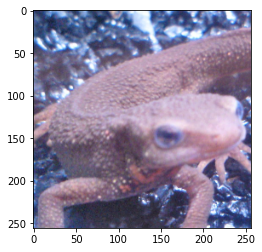

In [2]:
img_base_url = "https://yoyoyo-yo.github.io/Gasyori100knock/"
img_orig = io.imread(img_base_url + "dataset/images/imori_256x256.png")
plt.imshow(img_orig)

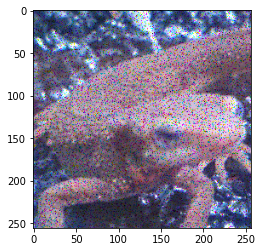

In [3]:
img_noise_orig = io.imread(img_base_url + 'dataset/images/imori_256x256_noise.png')
plt.imshow(img_noise_orig)

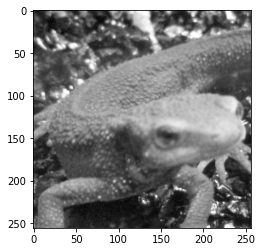

In [4]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

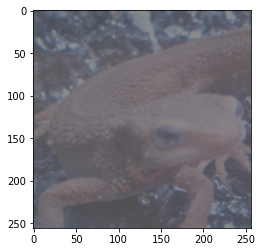

In [5]:
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
plt.imshow(img_dark)

In [6]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)

## Question 31 アフィン変換（スキュー） Affine transmation (skew)

1. アフィン変換を用いて、X-sharing(dx = 30)画像を作成せよ。
2. アフィン変換を用いて、Y-sharing(dy = 30)画像を作成せよ。
3. アフィン変換を用いて、幾何変換した(dx = 30, dy = 30)画像を作成せよ。

このような画像はスキュー画像と呼ばれ、画像を斜め方向に伸ばした画像である。

出力(1)の場合、x方向にdxだけ引き伸ばした画像はX-shearingと呼ばれる。

出力(2)の場合、y方向にdyだけ引き伸ばした画像はY-shearingと呼ばれる。

それぞれ次式のアフィン変換で実現できる。 ただし、元画像のサイズがh x wとする。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/affine_xysharing.png)

In [7]:
def affine(img, affine_mat, out_shape):
    h, w, ch = img.shape

    [a, b, tx], [c, d, ty] = affine_mat
    out_h, out_w = out_shape

    out = np.zeros([out_h, out_w, ch])

    img_pad = np.pad(img, [(1, 1), (1, 1), (0, 0)])
    # img_pad = img

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.maximum(np.minimum((1 / (a * d - b * c) * (d * xs - b * ys) - tx).astype(int) + 1, w + 1), 0)
    _ys = np.maximum(np.minimum((1 / (a * d - b * c) * (-c * xs + a * ys) - ty).astype(int) + 1, h + 1), 0)

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

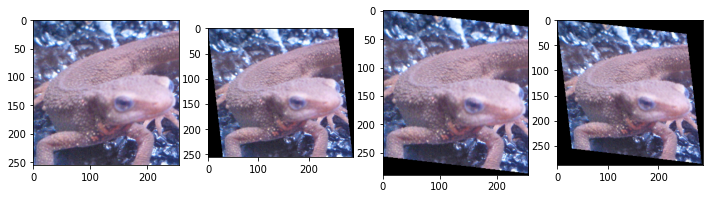

In [8]:
h, w, c = img_orig.shape

plt.figure(figsize=(12, 9))
plt.subplot(1, 4, 1); plt.imshow(img_orig)
plt.subplot(1, 4, 2); plt.imshow(affine(img_orig, [[1, 30 / w, 0], [0, 1, 0]], (h, int(w * 1.13))))
plt.subplot(1, 4, 3); plt.imshow(affine(img_orig, [[1, 0, 0], [30 / h, 1, 0]], (int(h * 1.13), w)))
plt.subplot(1, 4, 4); plt.imshow(affine(img_orig, [[1, 30 / w, 0], [30 / h, 1, 0]], (int(h * 1.13), int(w * 1.13))))
plt.show()

## Question 32 フーリエ変換 Fourier transformation

二次元離散フーリエ変換（DFT）を実装し、グレースケールの周波数のパワースペクトルを表示せよ。また、逆二次元離散フーリエ変換（IDFT）で画像を復元せよ。

二次元離散フーリエ変換（DFT: Discrete Fourier Transformation）とはフーリエ変換の画像に対する処理方法である。

通常のフーリエ変換はアナログ信号や音声などの連続値かつ一次元を対象に周波数成分を求める計算処理である。一方、ディジタル画像は\[0, 255\]の離散値をとり、かつ画像はHxWの二次元表示であるので、二次元離散フーリエ変換が行われる。

二次元離散フーリエ変換（DFT）は次式で計算される。

K = \[0, W-1\], I = \[0, H-1\], 入力画像をIとして

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/dft.png)

ここではグレースケール画像から二次元離散フーリエ変換を行う。

パワースペクトル：Gは複素数で表されるので、Gの絶対値を求めることである。今回のみ画像表示の時はパワースペクトルは\[0, 255\]にスケーリングせよ。

逆二次元離散フーリエ変換（IDFT: Inverse DFT）とは周波数成分Gから元の画像を復元する手法であり、次式で定義される。

x = \[0, W-1\], y = \[0, H-1\]として

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/idft.png)

上が定義式であるが、exp(j)は複素数の値をとってしまうので、実際にコードにするときは下式のように絶対値を使う。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/idft_abs.png)

> 画像の高周波成分は細かい描き込みの成分で、画像の低周波成分はだいたいの輪郭などの成分

> 基本手的に低周波成分の方が多く含まれている

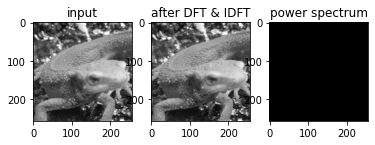

In [10]:
# DFT
def dft(img):
    H, W = img.shape
    G = np.zeros((H, W), dtype=complex)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))

    for l in range(H):
        for k in range(W):
            G[l, k] = np.sum(img * np.exp(-2j * np.pi * (x * k / W + y * l / H)))

    return G

# IDFT
def idft(G):
    H, W = G.shape
    out = np.zeros((H, W), dtype=np.float32)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))
    
    for l in range(H):
        for k in range(W):
            out[l, k] = np.abs(np.sum(G * np.exp(2j * np.pi * (x * k / W + y * l / H)))) / (H * W)

    # clipping
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

# DFT
G = dft(img_gray)

# power spectrum
ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)

# IDFT
out = idft(G)

plt.subplot(1, 3, 1)
plt.title("input")
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("after DFT & IDFT")
plt.imshow(out, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("power spectrum")
plt.imshow(ps, cmap="gray")
plt.show()

In [19]:
# 複素数型
type(1j)

complex

In [11]:
img_balloon = cv2.imread("color/Balloon.bmp")
img_balloon = img_balloon[..., ::-1]

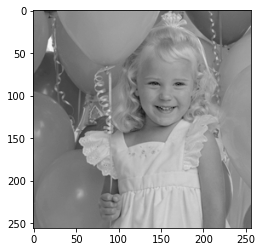

In [12]:
balloon_gray = cv2.cvtColor(img_balloon, cv2.COLOR_RGB2GRAY)
plt.imshow(balloon_gray, cmap='gray')

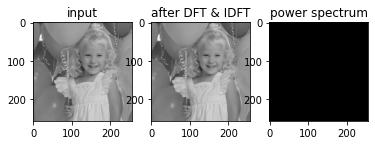

In [14]:
# DFT
G = dft(balloon_gray)

# power spectrum
ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)

# IDFT
out = idft(G)

plt.subplot(1, 3, 1)
plt.title("input")
plt.imshow(balloon_gray, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("after DFT & IDFT")
plt.imshow(out, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("power spectrum")
plt.imshow(ps, cmap="gray")
plt.show()

In [23]:
ps

array([[255,  17,   1, ...,   6,   1,  17],
       [ 10,   8,   5, ...,   2,   6,   2],
       [  3,   3,   1, ...,   0,   1,   6],
       ...,
       [  2,   1,   3, ...,   1,   0,   4],
       [  3,   6,   1, ...,   2,   1,   3],
       [ 10,   2,   6, ...,   2,   5,   8]], dtype=uint8)

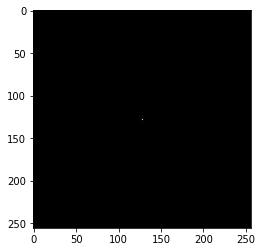

In [22]:
H, W = ps.shape

h_half = H // 2
w_half = W // 2
    
# transfer positions
_ps = np.zeros_like(ps)
_ps[:h_half, :w_half] = ps[h_half:, w_half:]
_ps[:h_half, w_half:] = ps[h_half:, :w_half]
_ps[h_half:, :w_half] = ps[:h_half, w_half:]
_ps[h_half:, w_half:] = ps[:h_half, :w_half]

plt.imshow(_ps, cmap="gray")
plt.show()

## Question 33 フーリエ変換 ローパスフィルタ

ローパスフィルタを通してIDFTで画像を復元せよ。
DFTによって得られた周波数成分は左上、右上、左下、右下に近いほど低周波数の成分を含んでいることになり、中心に近いほど高周波成分を示す。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/lpf.png)

画像における高周波成分とは色が変わっている部分（ノイズや輪郭など）を示し、低周波成分とは色があまり変わっていない部分（夕日のグラデーションなど）を表す。 ここでは、高周波成分をカットし、低周波成分のみを通すローパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.5rまでの成分を通すとする。

In [19]:
def lpf(G, ratio=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)

    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r > (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_lpf = lpf(G)
out_lpf = idft(G_lpf)

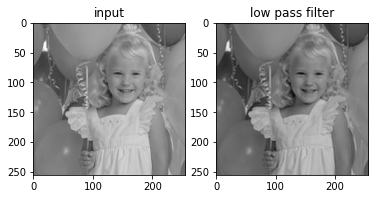

In [18]:
plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(balloon_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("low pass filter")
plt.imshow(out_lpf, cmap="gray")
plt.show()

## Question 34 フーリエ変換 ハイパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分をカットし、高周波成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rからの成分を通すとする。


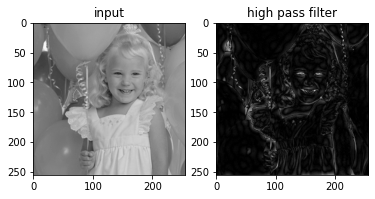

In [20]:
def hpf(G, ratio=0.1):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r < (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_hpf = hpf(G)
out_hpf = idft(G_hpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(balloon_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("high pass filter")
plt.imshow(out_hpf, cmap="gray")
plt.show()

## Question 35 フーリエ変換 バンドパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分と高周波成分の中間の周波数成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rから0.5rまでの成分を通すとする。


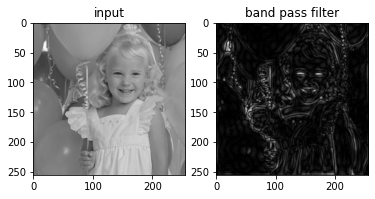

In [21]:
def bpf(G, low=0.1, high=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[(r < (h_half * low)) | (r > (h_half * high))] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_bpf = bpf(G)
out_bpf = idft(G_bpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(balloon_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("band pass filter")
plt.imshow(out_bpf, cmap="gray")
plt.show()

## Question 36 JPEG圧縮（Step 1）離散コサイン変換

グレースケールを離散コサイン変換を行い、逆離散コサイン変換を行え。

離散コサイン変換(DCT: Discrete Cosine Transformation)とは、次式で定義される周波数変換の一つである。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/dct.png)

逆離散コサイン変換(IDCT: Inverse Discrete Cosine Transformation)とは離散コサイン変換の逆（復号）であり、次式で定義される。 ここでいう K は復元時にどれだけ解像度を良くするかを決定するパラメータである。 K = Tの時は、DCT係数を全部使うのでIDCT後の解像度は最大になるが、Kが１や２などの時は復元に使う情報量（DCT係数）が減るので解像度が下がる。これを適度に設定することで、画像の容量を減らすことができる。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/idct.png)

ここでは画像を8x8ずつの領域に分割して、各領域で以上のDCT, IDCTを繰り返すことで、jpeg符号に応用される。 今回も同様に8x8の領域に分割して、DCT, IDCTを行え。

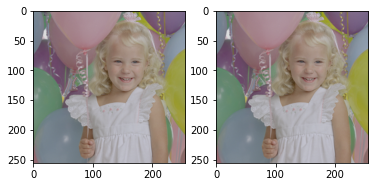

In [27]:
# DCT hyoer-parameter

# DCT
def dct(img, T=8, channel=3):
    H, W, _ = img.shape
    F = np.zeros((H, W, channel), dtype=np.float32)
    
    theta = np.pi / (2 * T)

    for c in range(channel):
        for vi in range(0, H, T):
            for ui in range(0, W, T):
                for v in range(T):
                    for u in range(T):
                        cu = 1 / np.sqrt(2) if u == 0 else 1
                        cv = 1 / np.sqrt(2) if v == 0 else 1
                        coef1, coef2 = np.meshgrid(np.cos((2 * np.arange(0, T) + 1) * u * theta), np.cos((2 * np.arange(0, T) + 1) * v * theta))
                        F[vi + v, ui + u, c] = 2 * cu * cv * np.sum(img[vi : vi + T, ui : ui + T, c] * coef1 * coef2) / T
                        
    return F


# IDCT
def idct(F, T=8, K=8, channel=3):
    H, W, _ = F.shape
    out = np.zeros((H, W, channel), dtype=np.float32)

    theta = np.pi / (2 * T)
    
    c_mat = np.ones([T, T])
    c_mat[0] /= np.sqrt(2)
    c_mat[:, 0] /= np.sqrt(2)
    
    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for y in range(T):
                    for x in range(T):
                        coef1, coef2 = np.meshgrid(np.cos((2 * x + 1) * np.arange(0, T) * theta), np.cos((2 * y + 1) * np.arange(0, T) * theta))
                        out[yi + y, xi + x, c] = 2 * np.sum(F[yi : yi + K, xi : xi + K, c] * coef1[:K, :K] * coef2[:K, :K] * c_mat[:K, :K]) / T

    out = np.clip(out, 0, 255)
    out = np.round(out).astype(np.uint8)

    return out

# DCT
F = dct(img_balloon)

# IDCT
out = idct(F)

plt.subplot(1, 2, 1)
plt.imshow(img_balloon)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

## Question 37 PSNR

IDCTで用いるDCT係数を8でなく、4にすると画像の劣化が生じる。 入力画像とIDCT画像のPSNRを求めよ。また、IDCTによるビットレートを求めよ。

**PSNR(Peak Signal to Noise Ratio)** は信号対雑音比と呼ばれ、画像がどれだけ劣化したかを示す。

PSNRが大きいほど、画像が劣化していないことを示し、次式で定義される。 v_maxは取りうる値の最大値で[0,255]の表示なら v_max=255　となる。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/psnr.png)

式中のMSEは **Mean Squared Error(平均二乗誤差)** と呼ばれ、二つの画像の差分の二乗の平均値を示す。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/mse.png)

ビットレートとは8x8でDCTを行い、IDCTでKxKの係数までを用いた時に次式で定義される。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/bitrate.png)

In [30]:
# MSE
def mse(img1, img2):
    h, w, c = img1.shape
    mse = np.sum((img1 - img2) ** 2) / (h * w * c)
    return mse

# PSNR
def psnr(img1, img2, vmax=255):
    _mse = 1e-10 if mse(img1, img2) == 0 else mse(img1, img2)
    return 10 * np.log10(vmax * vmax / _mse)

# bitrate
def bitrate(t, k):
    return 1. * t * (k ** 2) / (t ** 2)

# dct coef = 8
print("MSE =", mse(img_balloon, out))
print("PSNR =", psnr(img_balloon, out))
print("Bitrate =", bitrate(8, 8))

MSE = 0.0
PSNR = 148.13080360867912
Bitrate = 8.0


MSE = 11.482472737630209
PSNR = 37.53044937904518
Bitrate = 2.0


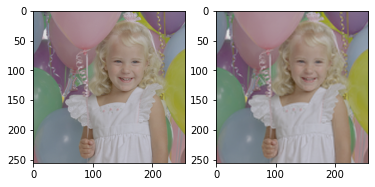

In [32]:
# DCT
F = dct(img_balloon, T=8)
out = idct(F, T=8, K=4)

print("MSE =", mse(img_balloon, out))
print("PSNR =", psnr(img_balloon, out))
print("Bitrate =", bitrate(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_balloon)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

## Question 38 JPEG圧縮（Step 2）DCT+量子化

DCT係数を量子化し、IDCTで復元せよ。また、その時の画像の容量を比べよ。

DCT係数を量子化することはjpeg画像にする符号化で用いられる手法である。

量子化とは、値を予め決定された区分毎に値を大まかに丸め込む作業であり、floorやceil, roundなどが似た計算である。

JPEG画像ではDCT係数を下記で表される量子化テーブルに則って量子化する。 量子化では8x8の係数をQで割り、四捨五入する。その後Qを掛けることで行われる。 IDCTでは係数は全て用いるものとする。

（量子化テーブルが明確に分からなかったため、ここでは下記で行う。）

In [34]:
Q = np.array([[12, 18, 24, 30, 36, 42, 48, 54],
       [18, 24, 30, 36, 42, 48, 54, 60],
       [24, 30, 36, 42, 48, 54, 60, 66],
       [30, 36, 42, 48, 54, 60, 66, 72],
       [36, 42, 48, 54, 60, 66, 72, 78],
       [42, 48, 54, 60, 66, 72, 78, 84],
       [48, 54, 60, 66, 72, 78, 84, 90],
       [54, 60, 66, 72, 78, 84, 90, 96]])

MSE = 17.725438435872395
PSNR = 35.64483374675704
Bitrate = 2.0


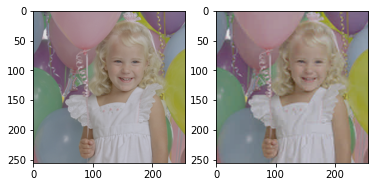

In [35]:
def quantization(F, T=8):
    h, w, channel = F.shape

    Q = np.array([[12, 18, 24, 30, 36, 42, 48, 54],
                       [18, 24, 30, 36, 42, 48, 54, 60],
                       [24, 30, 36, 42, 48, 54, 60, 66],
                       [30, 36, 42, 48, 54, 60, 66, 72],
                       [36, 42, 48, 54, 60, 66, 72, 78],
                       [42, 48, 54, 60, 66, 72, 78, 84],
                       [48, 54, 60, 66, 72, 78, 84, 90],
                       [54, 60, 66, 72, 78, 84, 90, 96]])

    for ys in range(0, h, T):
        for xs in range(0, w, T):
            for c in range(channel):
                F[ys: ys + T, xs: xs + T, c] =  np.round(F[ys: ys + T, xs: xs + T, c] / Q) * Q

    return F

F = dct(img_balloon)
F = quantization(F)
out = idct(F, K=4)

print("MSE =", mse(img_balloon, out))
print("PSNR =", psnr(img_balloon, out))
print("Bitrate =", bitrate(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_balloon)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

## Question 39 JPEG圧縮（Step 3）YCbCr表色系

YCbCr表色形において、Yを0.7倍してコントラストを暗くせよ。

YCbCr表色系とは、画像を明るさを表すY、輝度と青レベルの差Cb、輝度と赤レベルの差Crに分解する表現方法である。

これはJPEG変換で用いられる。

RGBからYCbCrへの変換は次式。

* Y = 0.299 * R + 0.5870 * G + 0.114 * B
* Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
* Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128

YCbCrからRGBへの変換は次式。

* R = Y + (Cr - 128) * 1.402
* G = Y - (Cb - 128) * 0.3441 - (Cr - 128) * 0.7139
* B = Y + (Cb - 128) * 1.7718

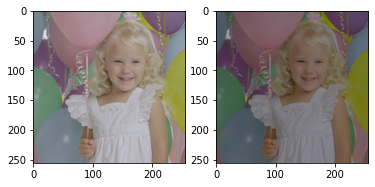

In [37]:
def rgb2ycbcr(img):
    h, w, _ = img.shape
    ycbcr = np.zeros([h, w, 3], dtype=np.float32)
    ycbcr[..., 0] = 0.2990 * img[..., 2] + 0.5870 * img[..., 1] + 0.1140 * img[..., 0]
    ycbcr[..., 1] = -0.1687 * img[..., 2] - 0.3313 * img[..., 1] + 0.5 * img[..., 0] + 128.
    ycbcr[..., 2] = 0.5 * img[..., 2] - 0.4187 * img[..., 1] - 0.0813 * img[..., 0] + 128.
    return ycbcr

# Y Cb Cr -> BGR
def ycbcr2rgb(ycbcr):
    h, w, _ = ycbcr.shape
    out = np.zeros([h, w, 3], dtype=np.float32)
    out[..., 2] = ycbcr[..., 0] + (ycbcr[..., 2] - 128.) * 1.4020
    out[..., 1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128.) * 0.3441 - (ycbcr[..., 2] - 128.) * 0.7139
    out[..., 0] = ycbcr[..., 0] + (ycbcr[..., 1] - 128.) * 1.7718
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

ycbcr = rgb2ycbcr(img_balloon)
ycbcr[..., 0] *= 0.7
out = ycbcr2rgb(ycbcr)

plt.subplot(1, 2, 1)
plt.imshow(img_balloon)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

## Question 40 JPEG圧縮（Step 4）YcbCr+DCT+量子化

YCbCr表色系に変換し、DCTを行った後に量子化し、IDCTで画像を復元せよ。

アルゴリズムは、

1. RGB を YCbCrに変換
2. YCbCrをDCT
3. DCTしたものを量子化
4. 量子化したものをIDCT
5. IDCTしたYCbCrをRGBに変換

これで画像の容量が小さくなっている（画像を保存して比較するとわかる）

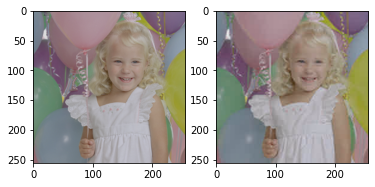

In [39]:
x = rgb2ycbcr(img_balloon)
x = dct(x)
x = quantization(x)
x = idct(x, K=4)
out = ycbcr2rgb(x)

plt.subplot(1, 2, 1)
plt.imshow(img_balloon)
plt.subplot(1, 2 ,2)
plt.imshow(out)
plt.show()

(array([1.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 9.000e+00, 1.100e+01,
        1.800e+01, 2.400e+01, 2.700e+01, 4.700e+01, 1.900e+01, 3.600e+01,
        3.800e+01, 7.400e+01, 1.220e+02, 1.110e+02, 1.230e+02, 1.280e+02,
        2.430e+02, 2.060e+02, 2.210e+02, 2.570e+02, 3.190e+02, 4.510e+02,
        5.510e+02, 8.020e+02, 8.870e+02, 1.092e+03, 6.990e+02, 7.120e+02,
        6.260e+02, 6.140e+02, 5.870e+02, 6.130e+02, 8.640e+02, 9.930e+02,
        1.991e+03, 1.771e+03, 2.130e+03, 2.647e+03, 3.002e+03, 3.511e+03,
        3.549e+03, 3.601e+03, 3.845e+03, 6.162e+03, 4.068e+03, 4.147e+03,
        3.895e+03, 3.875e+03, 4.142e+03, 4.214e+03, 4.118e+03, 5.045e+03,
        8.514e+03, 6.013e+03, 5.728e+03, 5.041e+03, 4.713e+03, 4.956e+03,
        4.968e+03, 3.658e+03, 2.905e+03, 4.755e+03, 4.009e+03, 4.608e+03,
        4.500e+03, 3.928e+03, 3.394e+03, 3.405e+03, 3.342e+03, 3.218e+03,
        5.176e+03, 4.095e+03, 3.217e+03, 2.670e+03, 2.553e+03, 2.693e+03,
        2.886e+03, 3.242e+03, 2.747e+0

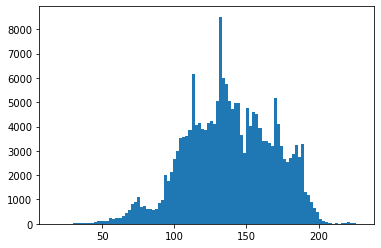

In [46]:
import matplotlib.pyplot as plt

plt.hist(img_balloon.flatten(), bins=100)

(array([2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        1.500e+01, 4.000e+00, 1.200e+01, 2.100e+01, 9.000e+00, 2.600e+01,
        1.700e+01, 3.400e+01, 3.200e+01, 4.600e+01, 1.140e+02, 9.500e+01,
        1.720e+02, 1.360e+02, 3.010e+02, 1.680e+02, 2.260e+02, 4.180e+02,
        5.240e+02, 7.340e+02, 7.600e+02, 1.040e+03, 7.890e+02, 7.900e+02,
        8.640e+02, 6.180e+02, 1.110e+03, 8.030e+02, 1.395e+03, 1.158e+03,
        1.538e+03, 2.568e+03, 2.580e+03, 4.245e+03, 3.610e+03, 5.452e+03,
        3.761e+03, 4.001e+03, 6.203e+03, 4.224e+03, 5.912e+03, 3.924e+03,
        6.543e+03, 4.593e+03, 5.079e+03, 7.883e+03, 5.645e+03, 8.401e+03,
        5.152e+03, 6.856e+03, 5.273e+03, 4.474e+03, 4.920e+03, 3.137e+03,
        5.990e+03, 4.140e+03, 6.404e+03, 3.687e+03, 3.318e+03, 4.964e+03,
        3.109e+03, 5.347e+03, 3.393e+03, 4.595e+03, 2.636e+03, 2.813e+03,
        4.154e+03, 2.843e+03, 4.220e+03, 1.796e+03, 1.951e+03, 9.970e+02,
        6.860e+02, 6.350e+02, 1.810e+0

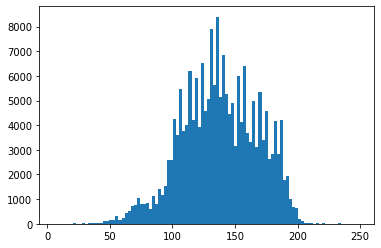

In [47]:
plt.hist(out.flatten(), bins=100)

In [50]:
plt.imsave('color/Balloon_jpeg.jpeg', out)